# import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import warnings 
warnings.filterwarnings("ignore")
import time

# DATA PREPARATION
## Load the training data and test data

In [2]:
column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
               's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
               's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_FD003 = pd.read_table("./CMAPSSData/train_FD003.txt", header=None, delim_whitespace=True)
train_FD003.columns = column_name
# Test 文件中的cycle数 并不是到死的
test_FD003 = pd.read_table("./CMAPSSData/test_FD003.txt", header=None, delim_whitespace=True)
test_FD003.columns = column_name

# load RUL data 真正的最后循环数存放在这里
RUL_FD003 = pd.read_table("./CMAPSSData/RUL_FD003.txt", header=None, delim_whitespace=True)

In [3]:
train_FD003.head()

,engine_id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


# Feature extention

## Difference with previous row

In [4]:
train_FD003 = train_FD003.drop(['s1','setting1','setting2','setting3','s5','s6','s10','s16','s18','s19'],axis = 1)

In [5]:
test_FD003 = test_FD003.drop(['s1','setting1','setting2','setting3','s5','s6','s10','s16','s18','s19'],axis = 1)

In [6]:
# _id =1
# s2_diff = []
# s2_diff_temp = []
# diff_periods = 40
# for _id in set(train_FD003[id]):
#     trainFD003_of_one_id =  train_FD003[train_FD003[id] == _id]
#     s2 = pd.Series(trainFD003_of_one_id['s2'])
#     for i in range(diff_periods):
#         s2_diff.append(s2.iloc[i]-s2.iloc[0])
#     s2_diff_temp=s2.diff(periods=diff_periods)
#     for j in range (len(s2)-diff_periods):
#         s2_diff.append(s2_diff_temp.iloc[diff_periods])


In [7]:
def cal_diff(df, sensor_name,diff_periods = 40):
    _id =1
    sensor_diff = []
    sensor_diff_temp = []
    for _id in set(df['engine_id']):
        trainFD003_of_one_id =  df[df['engine_id'] == _id]
        s = pd.Series(trainFD003_of_one_id[sensor_name])
        #判断每一个数列的长度是否大于diff_periods
        if len(s)>diff_periods:
            sensor_diff_temp=s.diff(periods=diff_periods)
            # 第0到39 应该是每一个值-第一个值
            for i in range(diff_periods):
                sensor_diff.append(s.iloc[i]-s.iloc[0])
            # 第40个值之后应该是每一个值-向前推40位的值
            for j in range (len(s)-diff_periods):
                sensor_diff.append(sensor_diff_temp.iloc[diff_periods+j])
        else:
            for h in range(len(s)):
                sensor_diff.append(s.iloc[h]-s.iloc[0])
    return sensor_diff

In [8]:
#from Feature_extention import cal_diff

In [9]:
#get all the names of sensors
list(train_FD003.columns)
sensor_name = list(train_FD003.columns)
sensor_name = sensor_name[2:16]
sensor_name

['s2',
 's3',
 's4',
 's7',
 's8',
 's9',
 's11',
 's12',
 's13',
 's14',
 's15',
 's17',
 's20',
 's21']

In [10]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(train_FD003,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    train_FD003[name] = diff

In [11]:
for i in range(len(sensor_name)):
    sensor_name_temp = sensor_name[i]
    diff = cal_diff(test_FD003,sensor_name=sensor_name_temp) 
    name = sensor_name_temp+'_diff'
    test_FD003[name] = diff

In [12]:
test_FD003

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s8_diff,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff
0,1,1,641.94,1581.93,1396.93,554.56,2387.93,9048.65,47.09,521.89,...,0.00,0.00,0.00,0.00,0.00,0.00,0.0000,0.0,0.00,0.0000
1,1,2,642.02,1584.86,1398.90,554.10,2387.94,9046.53,47.08,521.85,...,0.01,-2.12,-0.01,-0.04,0.07,3.96,0.0302,0.0,-0.03,0.0339
2,1,3,641.68,1581.78,1391.92,554.41,2387.97,9054.92,47.15,522.10,...,0.04,6.27,0.06,0.21,0.00,4.77,-0.0207,0.0,0.03,-0.0224
3,1,4,642.20,1584.53,1395.34,554.58,2387.94,9055.04,47.26,522.45,...,0.01,6.39,0.17,0.56,0.02,3.59,-0.0051,1.0,-0.10,0.0314
4,1,5,642.46,1589.03,1395.86,554.16,2388.01,9048.59,46.94,521.91,...,0.08,-0.06,-0.15,0.02,0.03,0.72,0.0386,0.0,0.02,-0.0518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16591,100,243,643.04,1594.99,1411.28,561.21,2388.24,9088.31,47.61,529.23,...,0.22,33.61,0.15,4.58,0.18,12.40,-0.0652,4.0,0.25,0.0898
16592,100,244,642.47,1591.27,1417.64,561.02,2388.29,9085.35,47.75,529.27,...,0.32,14.85,0.35,5.33,0.20,15.68,-0.0156,3.0,0.30,0.2358
16593,100,245,642.70,1593.81,1412.70,561.16,2388.23,9084.29,47.60,529.48,...,0.19,17.98,0.31,4.83,0.22,17.46,-0.0487,2.0,0.12,0.1274
16594,100,246,642.19,1595.63,1406.58,562.66,2388.24,9092.52,47.69,529.39,...,0.17,31.51,0.38,5.01,0.22,20.98,-0.0686,4.0,0.08,0.2325


In [13]:
train_FD003.describe()

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s8_diff,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff
count,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,...,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000,24720.000000
mean,48.631877,139.077063,642.457858,1588.079175,1404.471212,555.143808,2388.071555,9064.110809,47.415707,523.050873,...,0.042538,5.816199,0.100670,0.579972,0.042528,4.382954,-0.001234,0.535396,0.000442,0.000583
std,29.348985,98.846675,0.523031,6.810418,9.773178,3.437343,0.158285,19.980294,0.300074,3.255314,...,0.113189,12.152731,0.197499,1.636823,0.113507,9.886528,0.036818,1.495398,0.173808,0.103557
min,1.000000,1.000000,640.840000,1564.300000,1377.060000,549.610000,2386.900000,9017.980000,46.690000,517.770000,...,-0.980000,-31.270000,-0.620000,-3.110000,-0.950000,-25.510000,-0.171200,-5.000000,-0.660000,-0.470400
25%,23.000000,62.000000,642.080000,1583.280000,1397.187500,553.110000,2388.000000,9051.920000,47.190000,521.150000,...,-0.010000,-1.492500,-0.030000,-0.360000,-0.010000,-1.360000,-0.024500,0.000000,-0.110000,-0.067200
50%,47.000000,124.000000,642.400000,1587.520000,1402.910000,554.050000,2388.070000,9060.010000,47.360000,521.980000,...,0.030000,3.550000,0.090000,0.110000,0.030000,2.640000,-0.000600,0.000000,0.000000,0.000000
75%,74.000000,191.000000,642.790000,1592.412500,1410.600000,556.040000,2388.140000,9070.092500,47.600000,523.840000,...,0.070000,10.032500,0.220000,0.890000,0.080000,7.640000,0.023200,1.000000,0.120000,0.067700
max,100.000000,525.000000,645.110000,1615.390000,1441.160000,570.490000,2388.600000,9234.350000,48.440000,537.400000,...,1.030000,114.990000,1.090000,12.240000,1.030000,103.890000,0.133600,7.000000,0.820000,0.541700


## standard normalization 

In [14]:
#### standard normalization ####

# Training 因为前两列是没有用的 engine_id cycle
mean = train_FD003.iloc[:, 2:].mean()
std = train_FD003.iloc[:, 2:].std()
std.replace(0, 1, inplace=True)
train_FD003.iloc[:, 2:] = (train_FD003.iloc[:, 2:] - mean) / std

# Testing
test_FD003.iloc[:, 2:] = (test_FD003.iloc[:, 2:] - mean) / std

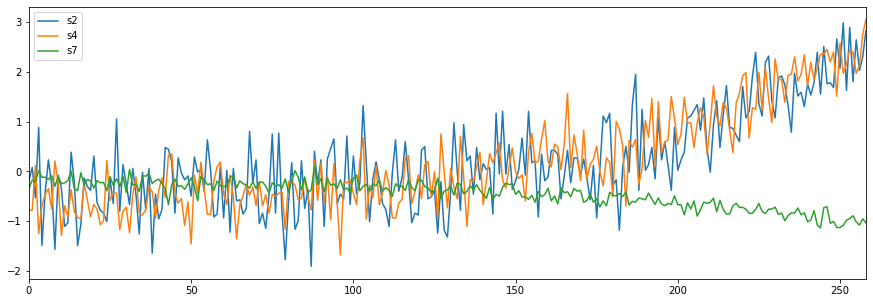

In [15]:
train_FD003[train_FD003["engine_id"]==1][["s2","s4","s7"]].plot(figsize=(15,5));

## Compute the RUL

### Training 

In [16]:
id='engine_id'
# 这个是自己定义的， 拐点在120 ，  120之前视为一样
MAXLIFE = 125
rul = [] # 会逐渐装满所有id的RUL
for _id in set(train_FD003[id]):
    trainFD003_of_one_id =  train_FD003[train_FD003[id] == _id]
    cycle_list = trainFD003_of_one_id['cycle'].tolist()
    # 因为这里是run to end ,所以最大cycle数是确定的
    max_cycle = max(cycle_list)
    # 计算出临界点的位置，没到达临界点的时候，全部保存MAXLIFE，到达临界点的时候，逐点下降！
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        # 
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)
    # 每跑完一个id就添加到最后总的rul列表中
    rul.extend(kink_RUL)

train_FD003["RUL"] = rul


### Testing

In [17]:
id='engine_id'
rul = []
for _id_test in set(test_FD003[id]):
    # 真实的RUL， 也就是测试数据最后一个周期所对应的RUL
    true_rul = int(RUL_FD003.iloc[_id_test - 1])
    testFD003_of_one_id =  test_FD003[test_FD003[id] == _id_test]
    cycle_list = testFD003_of_one_id['cycle'].tolist()
    # 那么总的生命周期数=训练集的已有周期数+最后剩下的周期数
    max_cycle = max(cycle_list) + true_rul
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - 1
            kink_RUL.append(tmp)    

    rul.extend(kink_RUL)

test_FD003["RUL"] = rul

In [18]:
min_shape = np.min([i[0] for i in train_FD003.groupby("engine_id").apply(np.shape).values])
print("训练集中最小的长度是：",min_shape)

训练集中最小的长度是： 145


In [19]:
min_shape = np.min([i[0] for i in test_FD003.groupby("engine_id").apply(np.shape).values])
print("测试集中最小的长度是：",min_shape)

测试集中最小的长度是： 38


In [20]:
train_FD003[train_FD003["engine_id"]==1].head()

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff,RUL
0,1,1,-0.187098,-0.712023,-0.780832,-0.341487,-0.704771,-0.097136,-0.385594,-0.227589,...,-0.478592,-0.509725,-0.354328,-0.374673,-0.443326,0.033507,-0.358029,-0.002544,-0.005632,125
1,1,2,0.080573,-0.497646,-0.775716,-0.172752,-0.452062,-0.116655,-0.618869,-0.193798,...,-0.510684,-0.864158,-0.287125,-0.198472,0.318317,0.459924,0.310689,-0.692962,0.915601,125
2,1,3,-0.531246,-0.841237,0.116522,-0.207663,-0.262530,0.306261,-0.652194,-0.313602,...,0.184633,-0.914791,-0.525391,-0.462774,0.047241,-0.903524,-0.358029,-1.498450,0.121834,125
3,1,4,0.883584,-0.362559,-1.248439,0.019257,-0.452062,0.022982,-0.585544,-0.172294,...,-0.281105,-0.813524,-0.244359,0.242031,-0.317903,-0.965993,0.310689,-0.865567,-0.571505,125
4,1,5,-1.487212,0.080880,-0.697952,-0.117477,-0.199353,0.602053,-0.885470,-0.144647,...,0.670944,-1.269224,-0.189374,-0.198472,-0.192480,-0.990437,0.310689,0.170061,1.004441,125


### 去掉不变的sensor的值和setting

In [21]:
train_FD003

,engine_id,cycle,s2,s3,s4,s7,s8,s9,s11,s12,...,s9_diff,s11_diff,s12_diff,s13_diff,s14_diff,s15_diff,s17_diff,s20_diff,s21_diff,RUL
0,1,1,-0.187098,-0.712023,-0.780832,-0.341487,-0.704771,-0.097136,-0.385594,-0.227589,...,-0.478592,-0.509725,-0.354328,-0.374673,-0.443326,0.033507,-0.358029,-0.002544,-0.005632,125
1,1,2,0.080573,-0.497646,-0.775716,-0.172752,-0.452062,-0.116655,-0.618869,-0.193798,...,-0.510684,-0.864158,-0.287125,-0.198472,0.318317,0.459924,0.310689,-0.692962,0.915601,125
2,1,3,-0.531246,-0.841237,0.116522,-0.207663,-0.262530,0.306261,-0.652194,-0.313602,...,0.184633,-0.914791,-0.525391,-0.462774,0.047241,-0.903524,-0.358029,-1.498450,0.121834,125
3,1,4,0.883584,-0.362559,-1.248439,0.019257,-0.452062,0.022982,-0.585544,-0.172294,...,-0.281105,-0.813524,-0.244359,0.242031,-0.317903,-0.965993,0.310689,-0.865567,-0.571505,125
4,1,5,-1.487212,0.080880,-0.697952,-0.117477,-0.199353,0.602053,-0.885470,-0.144647,...,0.670944,-1.269224,-0.189374,-0.198472,-0.192480,-0.990437,0.310689,0.170061,1.004441,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,2.527846,1.164514,2.009458,-0.955333,1.127368,0.335790,2.846941,-1.041642,...,0.481686,2.325739,-1.087456,1.123036,-0.145952,1.220413,-1.026747,-0.692962,-2.701735,4
24716,100,149,1.590999,1.218842,2.524132,-0.955333,1.001014,0.024484,2.380389,-0.964845,...,0.468520,2.224472,-0.891955,0.770634,0.238410,1.326338,-0.358029,-0.980636,-2.371482,3
24717,100,150,2.642562,2.415538,2.756400,-1.118250,1.127368,-0.033073,2.547015,-1.109224,...,0.745824,2.528272,-0.995815,0.506332,-0.278455,1.445844,0.979407,-2.361473,-0.227732,2
24718,100,151,2.833755,1.392106,2.261167,-1.295712,1.190545,-0.094634,2.113788,-0.934126,...,0.573846,1.515606,-0.812533,0.858734,0.187836,0.310542,-0.358029,-2.246403,-0.608200,1


### plot a figure

training (24720, 28) (24720,)
testing (16596, 28) (16596,)


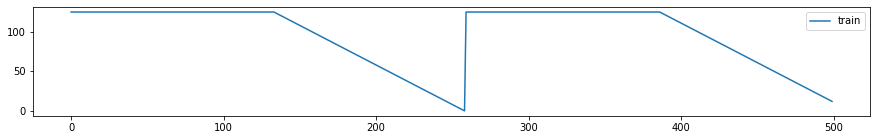

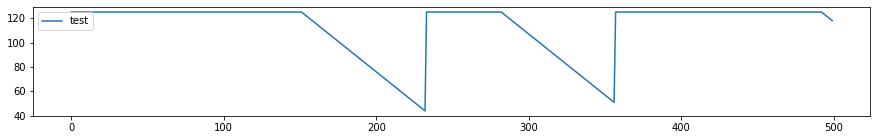

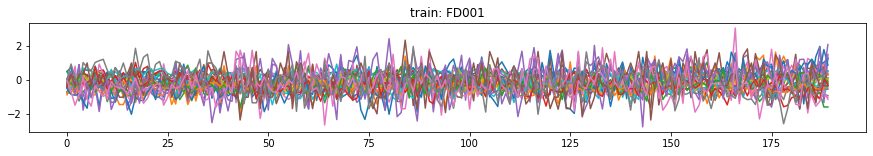

In [22]:
training_data = train_FD003.values
testing_data = test_FD003.values

x_train = training_data[:, 2:-1]
y_train = training_data[:, -1]
print("training", x_train.shape, y_train.shape)

x_test = testing_data[:, 2:-1]
y_test = testing_data[:, -1]
print("testing", x_test.shape, y_test.shape)
# 训练数据集 前面500个数据点所对应的rul 由图中可以看出  都是到零的了
plt.figure(figsize=(15,2))
plt.plot(y_train[:500], label="train")
plt.legend()
plt.figure(figsize=(15,2))
# 测试数据中前500个数据点对应的tul  可以看到结尾数据的rul 都不是中间
plt.plot(y_test[:500], label="test")
plt.legend()
plt.figure(figsize=(15,2))
plt.plot(x_train[:190])
plt.title("train: FD00" + str(1))
# 训练数据第一个id的 24个senor的值 可以通过在x轴坐标100的位置 序列的一些 趋势

plt.show()

In [23]:
def batch_generator(training_data, sequence_length=15, window_size = 15):
    """
    Generator function for creating random batches of training-data for many to many models
    """
    engine_ids = list(training_data["engine_id"].unique())
    temp = training_data.copy()
    # 把 每一段后一截给截掉，获取能够跑的index
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # cutoff_cycle 记录下这以后的index就不满足 序列大小的需求的
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 1
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            drop_range = indexes
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle+2].index
            drop_range = list(range(cutoff_cycle_index[0], indexes[-1] + 1))
            
        temp.drop(drop_range, inplace=True)
    indexes = temp.index
    del temp
    

    x_shape = (len(indexes), sequence_length, window_size, 28)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(indexes), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    
    # 第一个数据集
    alt_index = indexes[0]
    for batch_index, index in enumerate(indexes):
        # 因为对齐的原因，都减去了1
        y_batch[batch_index] = training_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        # 本来应该下面这个 for 循环的，但是考虑到循环的嵌套，跑太久了，而且窗口序列之间又有重复，那么减少循环的次数
        # for seq in range(sequence_length):
            # x_batch[index,seq] = training_data.iloc[idx+seq:idx+seq + window_size, 2:-1].values
        
        if index-alt_index==1 and batch_index!=0:
            temp_window = training_data.iloc[index+sequence_length-1:index+sequence_length-1 + window_size, 2:-1].values.reshape(1,window_size,-1)
            x_batch[batch_index] = np.concatenate((x_batch[batch_index-1][1:],temp_window))
        else:
            for seq in range(sequence_length):
                x_batch[batch_index][seq] = training_data.iloc[index+seq:index+seq + window_size, 2:-1].values
        alt_index = index
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

from tensorflow.python.keras import activations
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import constraints
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.engine.base_layer import Layer
from tensorflow.python.keras.layers.recurrent import DropoutRNNCellMixin
from tensorflow.python.keras.utils import conv_utils
from tensorflow.python.ops import array_ops
from tensorflow.python.util.tf_export import keras_export
from tensorflow.compat.v2.keras.layers import ConvLSTM2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
#from tensorflow.keras.layers.convolutional import Conv3D
#from tensorflow.keras.layers.convolutional_recurrent import ConvLSTM2D
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.python.keras.layers.recurrent import RNN
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.engine.input_spec import InputSpec
from tensorflow.python.keras.layers.recurrent import _standardize_args
from tensorflow.python.keras.utils import generic_utils


In [26]:
sequence_length=5
window_size = 24
kernel_size = 3

In [27]:
x_batch, y_batch =batch_generator(train_FD003,sequence_length=sequence_length,window_size = window_size)
# 这里需要把输入数据增加一个channel层数
x_batch = np.expand_dims(x_batch, axis=4)
y_batch = np.expand_dims(y_batch, axis=2)

In [28]:
y_batch

array([[[125.],
        [125.],
        [125.],
        [125.],
        [125.]],

       [[125.],
        [125.],
        [125.],
        [125.],
        [125.]],

       [[125.],
        [125.],
        [125.],
        [125.],
        [125.]],

       ...,

       [[  6.],
        [  5.],
        [  4.],
        [  3.],
        [  2.]],

       [[  5.],
        [  4.],
        [  3.],
        [  2.],
        [  1.]],

       [[  4.],
        [  3.],
        [  2.],
        [  1.],
        [  0.]]], dtype=float32)

In [29]:
from ConvLSTM2D_2 import ConvLSTM2D_2

In [30]:
model =Sequential()
# input 的shape 应该是 （时间，行-window，列-sensor， channels）
# 参数个数怎么算？？？为啥改变filter个数，参数个数不是按比例增长
# 增加batch ？ 增加 dropout??
model.add(ConvLSTM2D_2(filters=10, kernel_size=(kernel_size, 28),input_shape=(None, window_size, 28, 1), padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(ConvLSTM2D_2(filters=20, kernel_size=(kernel_size, 1),padding='valid', return_sequences=True))
model.add(keras.layers.BatchNormalization())
model.add(TimeDistributed(Flatten()))
model.add(tf.compat.v2.keras.layers.Dropout(0.5))
model.add(TimeDistributed(Dense(units = 100, activation = "linear")))
model.add(TimeDistributed(Dense(units = 1, activation = "linear")))
model.compile(loss='mse', optimizer='Adam')

In [31]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D_2 (None, None, 20, 1, 10)   39700     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 20, 1, 10)   40        
_________________________________________________________________
conv_lst_m2d_2_1 (ConvLSTM2D (None, None, 16, 1, 20)   18080     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 16, 1, 20)   80        
_________________________________________________________________
time_distributed (TimeDistri (None, None, 320)         0         
_________________________________________________________________
dropout (Dropout)            (None, None, 320)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 100)         3

In [32]:
model.fit(x_batch,y_batch, batch_size=15, epochs=30, validation_split=0.05)

Train on 20919 samples, validate on 1101 samples
Epoch 1/30
20919/20919 [==============================] - 57s 3ms/sample - loss: 591.5960 - val_loss: 127.2251
Epoch 2/30
20919/20919 [==============================] - 51s 2ms/sample - loss: 176.8595 - val_loss: 251.2647
Epoch 3/30
20919/20919 [==============================] - 51s 2ms/sample - loss: 147.6889 - val_loss: 141.8946
Epoch 4/30
20919/20919 [==============================] - 51s 2ms/sample - loss: 123.9665 - val_loss: 214.3652
Epoch 5/30
20919/20919 [==============================] - 50s 2ms/sample - loss: 99.0764 - val_loss: 163.9823
Epoch 6/30
20919/20919 [==============================] - 50s 2ms/sample - loss: 82.0044 - val_loss: 182.9500
Epoch 7/30
20919/20919 [==============================] - 50s 2ms/sample - loss: 70.5652 - val_loss: 140.4188
Epoch 8/30
20919/20919 [==============================] - 50s 2ms/sample - loss: 61.8949 - val_loss: 120.5832
Epoch 9/30
20919/20919 [==============================] - 50s 2ms/s

# Evaluation

## Tranining Performance

In [33]:
y_batch_pred = model.predict(x_batch)

In [34]:
from sklearn.metrics import mean_squared_error
y_batch_pred = y_batch_pred.reshape(y_batch_pred.shape[0], y_batch_pred.shape[1])
y_batch_reshape = y_batch.reshape(y_batch.shape[0], y_batch.shape[1])
np.sqrt(mean_squared_error(y_batch_pred, y_batch_reshape))

3.5702968

## Test Performance

## Evaluation Method 1

In [35]:
def test_batch_generator(test_data, sequence_length=15, window_size = 15):
    """
    这里的seq 和 win size 必须要和前面training的一致
    """
    engine_ids = list(test_data["engine_id"].unique())
    index_list=[]
    temp = test_data.copy()
    for id_ in engine_ids:
        indexes = temp[temp["engine_id"] == id_].index
        traj_data = temp.loc[indexes]
        # 找到对应的index，index以前的数据相当于抛弃了，，这个有待改进
        cutoff_cycle = max(traj_data['cycle']) - sequence_length - window_size + 2
        
        if cutoff_cycle<0:
            # 也就是步长和窗口大小已经大于了该机器的已有周期数，全部都得扔掉
            print("有一些数据直接就被抛弃了，请合理设置窗口大小和时间长度")
        else:
            cutoff_cycle_index = traj_data['cycle'][traj_data['cycle'] == cutoff_cycle].index
            index_list.append(cutoff_cycle_index.values[0])
            

    del temp
    

    x_shape = (len(index_list), sequence_length, window_size, 28)
    x_batch = np.zeros(shape=x_shape, dtype=np.float32)
    y_shape = (len(index_list), sequence_length)
    y_batch = np.zeros(shape=y_shape, dtype=np.float32)
    


    for test_index, index in enumerate(index_list):
        y_batch[test_index] = test_data.iloc[index+window_size-1:index+window_size-1+sequence_length,-1].values
        
        for seq in range(sequence_length):
            x_batch[test_index][seq] = test_data.iloc[index+seq:index+seq + window_size, 2:-1].values
    # 如果数据集过于大的情况下 应该使用yield来构成 循环的 generator、
    
    return x_batch, y_batch

In [36]:
x_batch_test, y_batch_test =  test_batch_generator(test_FD003, sequence_length=sequence_length,window_size = window_size)
x_batch_test = np.expand_dims(x_batch_test, axis=4)

In [37]:
y_batch_pred_test = model.predict(x_batch_test)

In [38]:
y_batch_pred_test = y_batch_pred_test.reshape(y_batch_pred_test.shape[0],y_batch_pred_test.shape[1])
y_batch_pred_last_values_test = [i[-1] for i in y_batch_pred_test]
y_batch_last_values_test = [i[-1] for i in y_batch_test]

In [39]:
np.sqrt(mean_squared_error(y_batch_pred_last_values_test, y_batch_last_values_test))

14.75216